In [1]:

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive


Mounted at /content/drive
/content/drive/My Drive


In [3]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 200 kB 40.5 MB/s 
     |████████████████████████████████| 199 kB 55.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=6706e955571e438c73d9b3bca464610500c87713e322cc4017fa235b25cc22a6
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()


In [30]:
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from pyspark.ml.tuning import CrossValidator
import plotly.graph_objects as go

In [10]:
data=spark.read.csv('heart.csv',inferSchema=True,header=True)

In [12]:
data.show(5)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows



In [13]:
data.count()

303

In [22]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [20]:
data.dtypes

[('age', 'int'),
 ('sex', 'int'),
 ('cp', 'int'),
 ('trestbps', 'int'),
 ('chol', 'int'),
 ('fbs', 'int'),
 ('restecg', 'int'),
 ('thalach', 'int'),
 ('exang', 'int'),
 ('oldpeak', 'double'),
 ('slope', 'int'),
 ('ca', 'int'),
 ('thal', 'int'),
 ('target', 'int')]

In [ ]:
"""
Feature Information:

1. age: The person’s age in years

2. sex: The person’s sex (1 = male, 0 = female)

3. cp: The chest pain experienced (0 = typical angina, 1= atypical angina, 2= non-anginal pain, 3 = asymptomatic)

4. trestbps: The person’s resting blood pressure (mm Hg on admission to the hospital)

5. chol: The person’s cholesterol measurement in mg/dl

6. fbs: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false).

7. restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes’ criteria)

8. thalach: The person’s maximum heart rate achieved

9. exang: Exercise induced angina (1 = yes; 0 = no)

10. oldpeak: ST depression induced by exercise relative to rest

11. slope: the slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)

12. ca: The number of major vessels (0–4)

13. thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)

14. target: Heart disease (0 = no, 1 = yes)
"""

In [ ]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

In [23]:
data.select('target').show(3)

+------+
|target|
+------+
|     1|
|     1|
|     1|
+------+
only showing top 3 rows



 missing value

In [27]:
pd_data =data.toPandas()
pd_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [35]:
data.groupby('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|  165|
|     0|  138|
+------+-----+



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



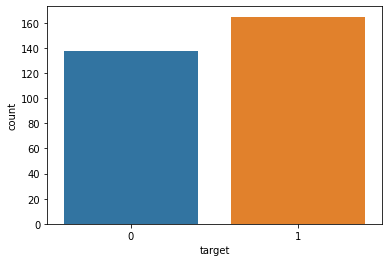

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(pd_data['target'])

In [51]:
data.groupby('sex').count().show()

+---+-----+
|sex|count|
+---+-----+
|  1|  207|
|  0|   96|
+---+-----+



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



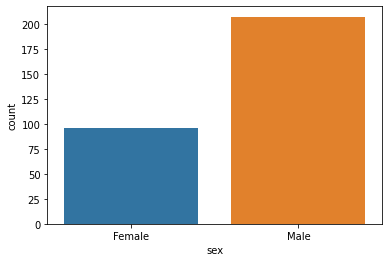

In [54]:
sns.countplot(pd_data['sex'])
plt.xticks([0,1],['Female', 'Male'])
plt.show()

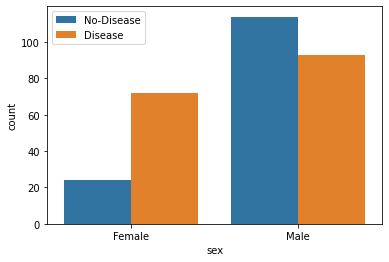

In [55]:
sns.countplot(x='sex',hue="target",data=pd_data)
plt.xticks([1,0],['Male','Female'])
plt.legend(labels = ['No-Disease','Disease'])
plt.show()

In [82]:
import pandas as pd

bins= [10,20,30,40,50,60,70,80,90]

labels = [2,3,4,5,6,7,8,9]
pd_data['AgeGroup'] = pd.cut(pd_data['age'], bins=bins, labels=labels, right=False)

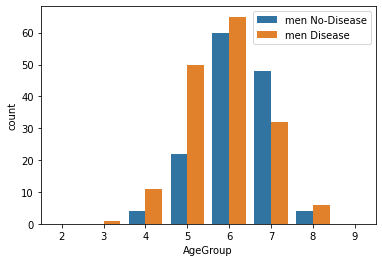

In [89]:
sns.countplot(x='AgeGroup',hue="target",data=pd_data)
plt.legend(labels = ['men No-Disease','men Disease'])
plt.show()

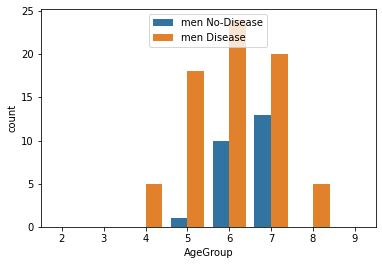

In [87]:
sns.countplot(x='AgeGroup',hue="target",data=pd_data.loc[pd_data['sex']!=1])
plt.legend(labels = ['men No-Disease','men Disease'])
plt.show()

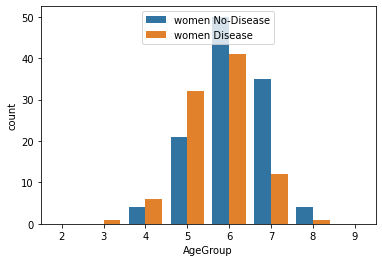

In [88]:
sns.countplot(x='AgeGroup',hue="target",data=pd_data.loc[pd_data['sex']!=0])
plt.legend(labels = ['women No-Disease','women Disease'])
plt.show()

In [43]:
data.groupby('target','cp').count().show()

+------+---+-----+
|target| cp|count|
+------+---+-----+
|     1|  0|   39|
|     1|  2|   69|
|     1|  1|   41|
|     1|  3|   16|
|     0|  0|  104|
|     0|  1|    9|
|     0|  2|   18|
|     0|  3|    7|
+------+---+-----+



In [26]:
from pyspark.sql.functions import col,sum
data.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in data.columns)).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [28]:
data.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|                cp|          trestbps|              chol|                fbs|          restecg|           thalach|              exang|           oldpeak|             slope|                ca|              thal|            target|
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               303|                303|               303|               303|               303|                303|              303|               303|    

In [31]:

df=pd_data.groupby('target').count().reset_index()[['target','age']].rename(columns={'age':'counts'})
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=df.target,
                             values=df.counts)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, textfont_color='black',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title='Heart Disease vs. Absence of Heart Disease', title_x=0.5)

In [33]:
corr = pd_data.corr()
fig = go.Figure(data=go.Heatmap(z=corr.values,
 x=corr.index.values,
 y=corr.columns.values,
 text=np.round(corr.values,2),
 texttemplate='%{text}'))
fig.update_layout(title=dict(font=dict(size=20), x=0.5))

In [37]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=['sex','cp','fbs','restecg','exang','slope','ca','thal'],
                           outputCols =['sexVec','cpVec','fbsVec','restecgVec','exangVec','slopeVec','caVec','thalVec'])
encoded =  encoder.fit(data).transform(data)
data_encoded = encoded.drop('sex','cp','fbs','restecg','exang','slope','ca','thal')
data_encoded.show()

+---+--------+----+-------+-------+------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|age|trestbps|chol|thalach|oldpeak|target|       sexVec|        cpVec|       fbsVec|   restecgVec|     exangVec|     slopeVec|        caVec|      thalVec|
+---+--------+----+-------+-------+------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 63|     145| 233|    150|    2.3|     1|    (1,[],[])|    (3,[],[])|    (1,[],[])|(2,[0],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(4,[0],[1.0])|(3,[1],[1.0])|
| 37|     130| 250|    187|    3.5|     1|    (1,[],[])|(3,[2],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(4,[0],[1.0])|(3,[2],[1.0])|
| 41|     130| 204|    172|    1.4|     1|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(1,[0],[1.0])|    (2,[],[])|(4,[0],[1.0])|(3,[2],[1.0])|
| 56|     120| 236|    178|    0.8|     1|    (1,[],[])|(3,[1],[1.0])|

In [38]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols =['age','trestbps','chol','thalach','oldpeak','sexVec','cpVec','fbsVec','restecgVec','exangVec','slopeVec','caVec','thalVec'],
                           outputCol="features")
assembled= assembler.transform(data_encoded)

data_asb =assembled.select("features","target")
data_asb.show()

+--------------------+------+
|            features|target|
+--------------------+------+
|(22,[0,1,2,3,4,10...|     1|
|(22,[0,1,2,3,4,8,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,4,7,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,4,6,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,7,9,...|     1|
|(22,[0,1,2,3,4,8,...|     1|
|(22,[0,1,2,3,4,8,...|     1|
|(22,[0,1,2,3,4,6,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,4,7,...|     1|
|(22,[0,1,2,3,4,9,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,5,8,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
|(22,[0,1,2,3,4,6,...|     1|
|(22,[0,1,2,3,4,5,...|     1|
+--------------------+------+
only showing top 20 rows



In [39]:
train_data, test_data = data_asb.randomSplit([.8,.2],seed=12)

In [40]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(labelCol="target", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8,family="binomial")

lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='target',predictionCol='prediction', metricName='accuracy')
lr_accuracy = evaluator.evaluate(lr_predictions)
print('Test Accuracy = ', lr_accuracy)

Test Accuracy =  0.5263157894736842


In [41]:


from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="target", featuresCol="features",smoothing=1.0, modelType="gaussian")

nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='target',predictionCol='prediction', metricName='accuracy')
nb_accuracy = evaluator.evaluate(nb_predictions)
print('Test Accuracy = ', nb_accuracy)



Test Accuracy =  0.8070175438596491


In [42]:


from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="target", featuresCol="features")

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='target',predictionCol='prediction', metricName='accuracy')
rf_accuracy = evaluator.evaluate(rf_predictions)
print('Test Accuracy = ', rf_accuracy)



Test Accuracy =  0.8245614035087719


In [44]:
from pyspark.ml.feature import PCA

pca = PCA(k=13, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(data_asb).transform(data_asb)

data_pca = model.select("pcaFeatures","target")
data_pca.head()

Row(pcaFeatures=DenseVector([-240.8323, 124.5393, 157.8559, 57.8458, -3.0528, 0.4427, -0.4674, 1.0292, 1.0155, -0.7207, -0.2413, -1.1992, 1.0616]), target=1)

In [45]:
train_pcadata, test_pcadata = data_pca.randomSplit([.8,.2],seed=12)

In [46]:

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="target", featuresCol="pcaFeatures")

rf_model = rf.fit(train_pcadata)
rf_predictions = rf_model.transform(test_pcadata)

evaluator = MulticlassClassificationEvaluator(labelCol='target',predictionCol='prediction', metricName='accuracy')
rf_accuracy = evaluator.evaluate(rf_predictions)
print('Test Accuracy = ', rf_accuracy)

Test Accuracy =  0.7894736842105263


In [47]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="target", featuresCol="pcaFeatures",smoothing=1.0, modelType="gaussian")

nb_model = nb.fit(train_pcadata)
nb_predictions = nb_model.transform(test_pcadata)

evaluator = MulticlassClassificationEvaluator(labelCol='target',predictionCol='prediction', metricName='accuracy')
nb_accuracy = evaluator.evaluate(nb_predictions)
print('Test Accuracy = ', nb_accuracy)


Test Accuracy =  0.8771929824561403
